In [1]:
import numpy as np 
import pandas as pd 
import math
import seaborn as sns
import datetime as dt
from datetime import datetime    
sns.set_style("whitegrid")
from pandas.plotting import autocorrelation_plot
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use("ggplot")


from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
import matplotlib.pyplot as plt


In [2]:
data = pd.read_csv('./meta.csv')
data.head()

# Reset index
data.reset_index(drop=True, inplace=True)

# Select numeric columns
numeric_data = data.select_dtypes(include=[np.number])

# Fill NaN values in numeric columns with the mean of those columns
data[numeric_data.columns] = data[numeric_data.columns].fillna(numeric_data.mean())

# Display the first few rows of the DataFrame
print(data.head())

# Calculate moving average
ma_day = [5, 10, 20, 50]  # Common short-term and long-term windows
for ma in ma_day:
    column_name = f"MA for {ma} days"
    data[column_name] = data['Close'].rolling(window=ma).mean()

# Calculate Exponential moving average
for ma in ma_day:
    column_name = f"EMA for {ma} days"
    data[column_name] = data['Close'].ewm(span=ma, adjust=False).mean()

# Volatility (Standard Deviation): Capture price fluctuations:
# for ma in ma_day:
#     column_name = f"Volatility_{ma}d"
#     data[column_name] = data['Close'].rolling(window=ma).std()

# Calculate RSI
def compute_RSI(data, window=14):
    delta = data['Close'].diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=window).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=window).mean()
    RS = gain / loss
    return 100 - (100 / (1 + RS))

# MACD
exp1 = data['Close'].ewm(span=12, adjust=False).mean()
exp2 = data['Close'].ewm(span=26, adjust=False).mean()
data['MACD'] = exp1 - exp2
data['Signal_Line'] = data['MACD'].ewm(span=9, adjust=False).mean()

data['RSI_14'] = compute_RSI(data)


data.dropna(inplace=True)
data.head(500)

         Date   Open   High    Low    Close     Volume
0  2012-05-18  42.05  45.00  38.00  38.2318  573576400
1  2012-05-21  36.53  36.66  33.00  34.0300  168192700
2  2012-05-22  32.61  33.59  30.94  31.0000  101786600
3  2012-05-23  31.37  32.50  31.36  32.0000   73600000
4  2012-05-24  32.95  33.21  31.77  33.0300   50237200


,Date,Open,High,Low,Close,Volume,MA for 5 days,MA for 10 days,MA for 20 days,MA for 50 days,EMA for 5 days,EMA for 10 days,EMA for 20 days,EMA for 50 days,MACD,Signal_Line,RSI_14
49,2012-07-30,23.995,24.04,23.030,23.15,29285900,26.29800,27.52000,29.237800,29.838636,25.546291,27.046144,28.449746,30.538853,-1.525536,-0.894611,15.733114
50,2012-07-31,23.370,23.37,21.610,21.71,56179400,24.95000,26.88200,28.784750,29.508200,24.267527,26.075936,27.807865,30.192623,-1.869091,-1.089507,14.602446
51,2012-08-01,21.500,21.58,20.840,20.88,44604400,23.25800,26.05900,28.268750,29.245200,23.138351,25.131220,27.148068,29.827422,-2.183168,-1.308239,13.890909
52,2012-08-02,20.770,20.84,19.820,20.04,56374500,21.89700,25.16300,27.697250,29.026000,22.105568,24.205544,26.471110,29.443602,-2.471369,-1.540865,13.172414
53,2012-08-03,20.360,22.16,19.900,21.09,80647000,21.37400,24.39600,27.165250,28.807800,21.767045,23.639081,25.958623,29.116010,-2.585243,-1.749740,22.638623
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
544,2014-07-21,68.810,69.96,68.500,69.40,49431600,67.81096,66.58973,66.626865,64.001716,68.007206,67.283914,66.478537,64.769416,1.037495,0.876412,56.251778
545,2014-07-22,69.760,69.77,68.610,69.27,40301800,68.23196,67.24073,66.821865,64.242316,68.428138,67.645020,66.744391,64.945909,1.134074,0.927944,53.726471
546,2014-07-23,69.740,71.33,69.610,71.29,77435900,68.95796,67.87273,67.100365,64.471516,69.382092,68.307744,67.177306,65.194697,1.357958,1.013947,64.538726
547,2014-07-24,75.960,76.74,74.510,74.98,124006900,70.67198,68.88348,67.477365,64.774516,71.248061,69.520881,67.920420,65.578435,1.812249,1.173608,71.536342


In [4]:
# Prepare features and target
# feature_columns = ['EMA for 50 days', 'RSI_14']  # Features we want to use

from xgboost import XGBRegressor


# Prepare features and target
feature_columns = [
    'Close', 
    'Volume', 
    'EMA for 50 days',
    'MACD',
    'RSI_14'
]

X = data[feature_columns].values
y = data['Close'].values

print("Total dataset shape:", X.shape)

# Calculate split point (80% training, 20% validation)
split_idx = int(len(X) * 0.8)

# Split the data chronologically for XGBoost
X_train_xgb = X[:split_idx]
X_val_xgb = X[split_idx:]
y_train_xgb = y[:split_idx]
y_val_xgb = y[split_idx:]

# Scale the data after splitting to prevent data leakage
feature_scaler = MinMaxScaler()
target_scaler = MinMaxScaler()

X_train_scaled = feature_scaler.fit_transform(X_train_xgb)
X_val_scaled = feature_scaler.transform(X_val_xgb)  # Only transform, don't fit
y_train_scaled = target_scaler.fit_transform(y_train_xgb.reshape(-1, 1))
y_val_scaled = target_scaler.transform(y_val_xgb.reshape(-1, 1))  # Only transform, don't fit

print("XGBoost Training set shape:", X_train_scaled.shape)
print("XGBoost Validation set shape:", X_val_scaled.shape)

# Train XGBoost model
xgb_model = XGBRegressor(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=5,
    random_state=42
)
xgb_model.fit(X_train_scaled, y_train_scaled)

# Make predictions on both train and validation sets
xgb_train_predictions = xgb_model.predict(X_train_scaled)
xgb_val_predictions = xgb_model.predict(X_val_scaled)

# For combining with LSTM later, stack the predictions back together
xgb_predictions = np.concatenate([xgb_train_predictions, xgb_val_predictions])

# Combine features with XGBoost predictions
X_train_combined = np.column_stack((X_train_scaled, xgb_train_predictions))
X_val_combined = np.column_stack((X_val_scaled, xgb_val_predictions))
combined_features = np.vstack((X_train_combined, X_val_combined))

Total dataset shape: (2624, 5)
XGBoost Training set shape: (2099, 5)
XGBoost Validation set shape: (525, 5)


In [5]:
import tensorflow as tf
from tensorflow.keras.layers import Conv1D, LSTM, Dense, Dropout, Bidirectional, TimeDistributed
from tensorflow.keras.layers import MaxPooling1D, Flatten, BatchNormalization, LeakyReLU
from tensorflow.keras.regularizers import L1L2
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam


# Create sequences for LSTM
sequence_length = 30
X_sequences = []
y_sequences = []

for i in range(len(combined_features) - sequence_length):
    X_sequences.append(combined_features[i:(i + sequence_length)])
    y_sequences.append(combined_features[i + sequence_length, -1])  # Take only the target variable

X_sequences = np.array(X_sequences)
y_sequences = np.array(y_sequences)

# Split data for LSTM
# X_train, X_val, y_train, y_val = train_test_split(
#     X_sequences, y_sequences, test_size=0.2, random_state=42
# )

# Calculate split point (80% training, 20% validation)
split_idx = int(len(X_sequences) * 0.8)

# Split data chronologically for LSTM
X_train = X_sequences[:split_idx]
X_val = X_sequences[split_idx:]
y_train = y_sequences[:split_idx]
y_val = y_sequences[split_idx:]

print("LSTM Training set shape:", X_train.shape)
print("LSTM Validation set shape:", X_val.shape)

# Create and train LSTM model
print("Training LSTM model...")
# lstm_model = Sequential([
#     LSTM(units=50, return_sequences=True, input_shape=(X_sequences.shape[1], X_sequences.shape[2])),
#     Dropout(0.2),
#     LSTM(units=50),
#     Dropout(0.2),
#     Dense(units=25),
#     Dense(units=1)
# ])



# LSTM model
lstm_model = Sequential([
    LSTM(100, return_sequences=True, 
         input_shape=(sequence_length, X_sequences.shape[2])),
    Dropout(0.2),
    
    LSTM(50, return_sequences=False),
    Dropout(0.2),
    
    Dense(25),
    Dense(1)
])

# def lr_schedule(epoch):
#     initial_lr = 0.0001  # Start with a smaller learning rate
#     if epoch < 10:
#         return initial_lr
#     elif epoch < 20:
#         return initial_lr * 2
#     elif epoch < 30:
#         return initial_lr * 3
#     else:
#         return initial_lr * 4


# Use original optimizer with slightly reduced learning rate
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0005)
lstm_model.compile(optimizer=optimizer, loss='mse', metrics=['mse', 'mae'])

# Modified callbacks
callbacks = [
    tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=15,
        restore_best_weights=True,
        verbose=1
    ),
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=5,
        min_lr=0.0001,
        verbose=1
    )
]

# Original training parameters
history = lstm_model.fit(
    X_train, 
    y_train,
    epochs=100,
    batch_size=32,
    validation_data=(X_val, y_val),
    callbacks=callbacks,
    verbose=1,
    shuffle=False
)

LSTM Training set shape: (2075, 30, 6)
LSTM Validation set shape: (519, 30, 6)
Training LSTM model...


c:\Users\timoz\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 5s 31ms/step - loss: 0.0034 - mae: 0.0472 - mse: 0.0034 - val_loss: 0.0175 - val_mae: 0.1077 - val_mse: 0.0175 - learning_rate: 5.0000e-04
Epoch 2/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: 0.0291 - mae: 0.1240 - mse: 0.0291 - val_loss: 0.0192 - val_mae: 0.1280 - val_mse: 0.0192 - learning_rate: 5.0000e-04
Epoch 3/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - loss: 0.0032 - mae: 0.0443 - mse: 0.0032 - val_loss: 0.0281 - val_mae: 0.1516 - val_mse: 0.0281 - learning_rate: 5.0000e-04
Epoch 4/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: 0.0021 - mae: 0.0374 - mse: 0.0021 - val_loss: 0.0156 - val_mae: 0.1040 - val_mse: 0.0156 - learning_rate: 5.0000e-04
Epoch 5/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: 0.0021 - mae: 0.0360 - mse: 0.0021 - val_loss: 0.0119 - val_mae: 0.0989 - val_mse: 0.0119 - learning_rate: 5.0000e-04
Epoch 6/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - loss: 0.0025 - mae: 0.0394 - mse: 0.0025 - val_loss: 0.0

In [7]:
# Make predictions
lstm_predictions = lstm_model.predict(X_sequences)
final_predictions = target_scaler.inverse_transform(lstm_predictions)

# final_predictions = target_scaler.inverse_transform(predictions.reshape(-1, 1))


82/82 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step


In [8]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

from sklearn.metrics import explained_variance_score, mean_poisson_deviance, mean_gamma_deviance
from sklearn.metrics import r2_score
from sklearn.metrics import max_error


# Get actual values
actual_values = y[sequence_length:]

# Calculate the split point for the last 20% of the data
split_idx = int(len(actual_values) * 0.8)

# Get only the validation portion (last 20%)
val_actual = actual_values[split_idx:]
val_predictions = final_predictions[split_idx:]

# Calculate metrics on validation set only
mse = mean_squared_error(val_actual, val_predictions)
rmse = np.sqrt(mse)
mae = mean_absolute_error(val_actual, val_predictions)
r2 = r2_score(val_actual, val_predictions)

print("\nPerformance Metrics:")
print(f"MSE: {mse:.2f}")
print(f"RMSE:{rmse:.2f} ")
print(f"MAE: {mae:.2f} ")
print(f"R2 Score: {r2:.4f} ")



Performance Metrics:
MSE: 636.28
RMSE:25.22 
MAE: 21.40 
R2 Score: 0.9087 


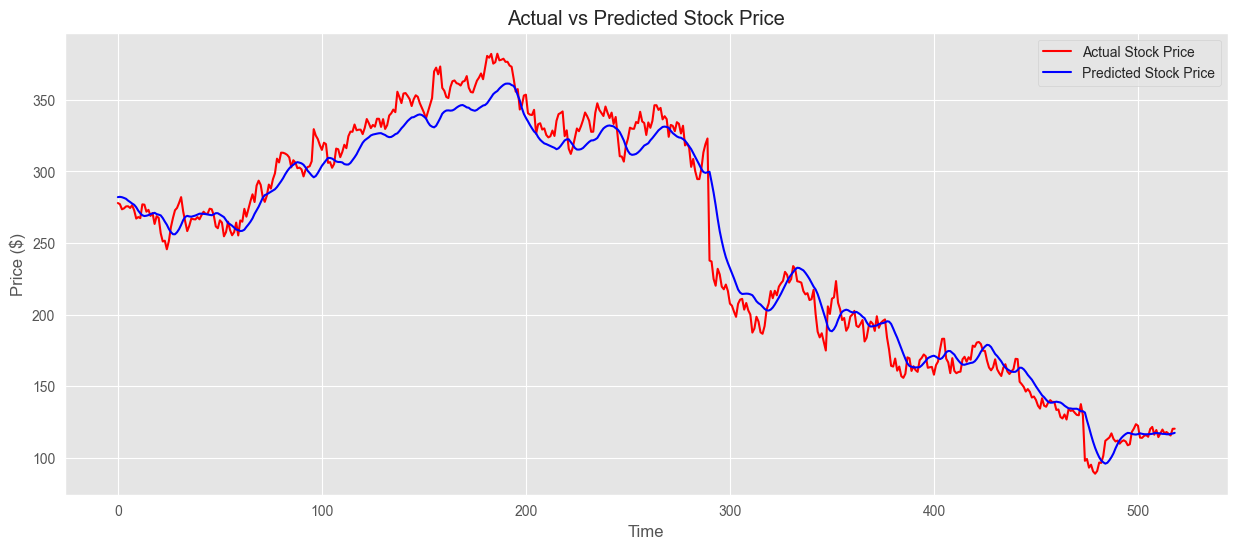

In [10]:
# Plot results
# plt.figure(figsize=(15, 6))
# plt.plot(actual_values, label='Actual Stock Price', alpha=0.8)
# plt.plot(final_predictions, label='Predicted Stock Price', alpha=0.8)
# plt.title('Stock Price Prediction: Actual vs Predicted')
# plt.xlabel('Time')
# plt.ylabel('Price ($)')
# plt.legend()
# plt.grid(True)
# plt.show()

# Plot only the validation results
plt.figure(figsize=(15, 6))
plt.plot(val_actual, label='Actual Stock Price', color = 'red')
plt.plot(val_predictions, label='Predicted Stock Price', color = 'blue')
plt.title('Actual vs Predicted Stock Price')
plt.xlabel('Time')
plt.ylabel('Price ($)')
plt.legend()
plt.grid(True)
plt.show()

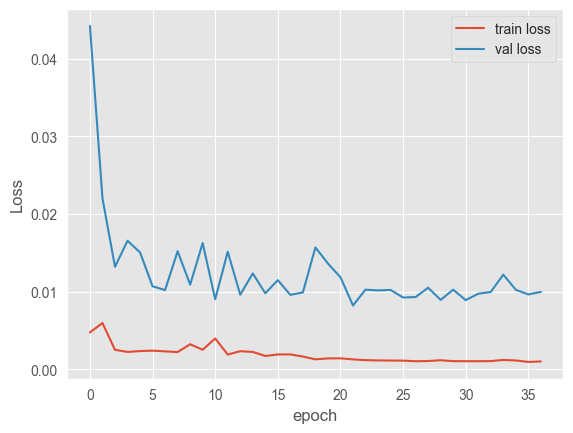

In [11]:
# loss
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.xlabel("epoch")
plt.ylabel("Loss")
plt.legend()

